# **Tool Wear Prediction**

# **1. Overview**

Prediction concept
* From dataset in this topic, Consist of 18 files of experiment record and another train data. 
* I decided to combine train dataset of each experiment number into new column of experiment dataset. 
* Choose feature to training model for predict feedrate and clamp_pressure.
* Get feedrate_predicted and clamp_pressure_predicted to training model for classify tool_condition

# **2. Import libraries**

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import  LogisticRegression
from sklearn import svm
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score

# **3. Load the dataset**

In [63]:
prefix = 'https://raw.githubusercontent.com/APL-Data-Intelligence/AceleraAI/main/Curso_NEED/datasets/cnc_dataset/'
train=pd.read_csv(prefix + 'train.csv')

Use function .info() for describe train dataframe

In [64]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   No                        18 non-null     int64  
 1   material                  18 non-null     object 
 2   feedrate                  18 non-null     int64  
 3   clamp_pressure            18 non-null     float64
 4   tool_condition            18 non-null     object 
 5   machining_finalized       18 non-null     object 
 6   passed_visual_inspection  14 non-null     object 
dtypes: float64(1), int64(2), object(4)
memory usage: 1.1+ KB
None


Use function .head() for show the first data 5 row 

In [65]:
print(train.head())

   No material  ...  machining_finalized  passed_visual_inspection
0   1      wax  ...                  yes                       yes
1   2      wax  ...                  yes                       yes
2   3      wax  ...                  yes                       yes
3   4      wax  ...                   no                       NaN
4   5      wax  ...                   no                       NaN

[5 rows x 7 columns]


# **4. Pre-Processing**

**Label Encoding**
   
       Use function "LabelEncoder" to transform non-numerical labels to numerical labels

In [66]:
le1=LabelEncoder()
le1.fit(train['material'])
train['Encoded_material']=le1.transform(train['material'])

le2=LabelEncoder()
le2.fit(train['tool_condition'])
train['Encoded_tool_condition']=le2.transform(train['tool_condition'])

le3=LabelEncoder()
le3.fit(train['machining_finalized'])
train['Encoded_machining_finalized']=le3.transform(train['machining_finalized'])

le4=LabelEncoder()
le4.fit(train['feedrate'])
train['Encoded_feedrate']=le4.transform(train['feedrate'])

le5=LabelEncoder()
le5.fit(train['clamp_pressure'])
train['Encoded_clamp_pressure']=le5.transform(train['clamp_pressure'])

        Use function .drop() remove columns by specifying label names

In [67]:
train.drop(['passed_visual_inspection','tool_condition','material','machining_finalized'],axis=1,inplace=True)
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   No                           18 non-null     int64  
 1   feedrate                     18 non-null     int64  
 2   clamp_pressure               18 non-null     float64
 3   Encoded_material             18 non-null     int64  
 4   Encoded_tool_condition       18 non-null     int64  
 5   Encoded_machining_finalized  18 non-null     int64  
 6   Encoded_feedrate             18 non-null     int64  
 7   Encoded_clamp_pressure       18 non-null     int64  
dtypes: float64(1), int64(7)
memory usage: 1.2 KB
None


**Feature Selection**

        plot the correlation heatmap and see the correlation of independent variables with the output variable

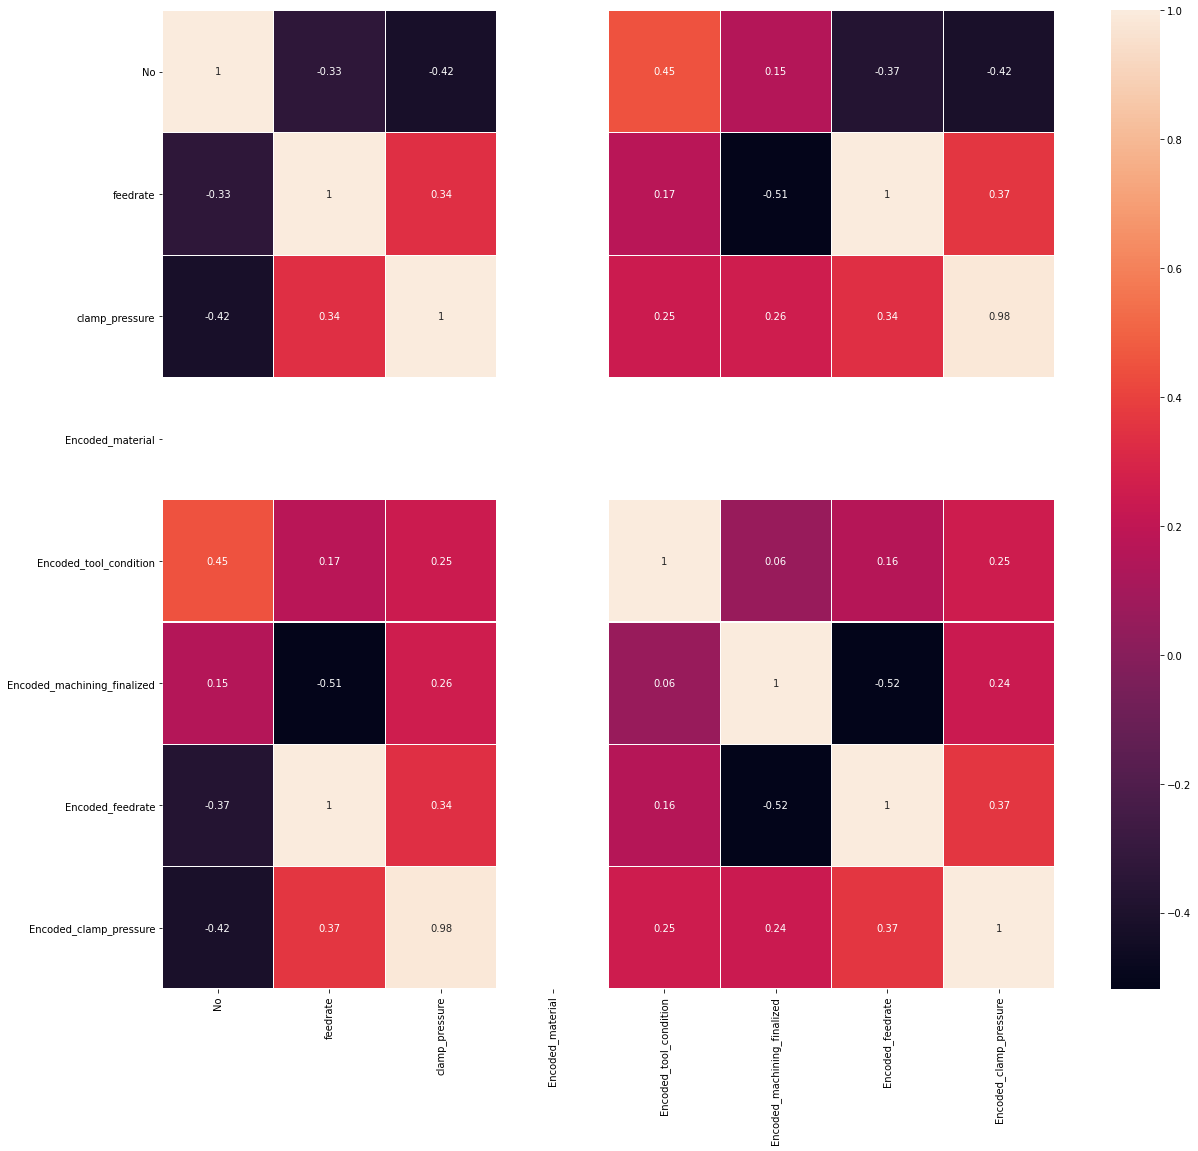

In [68]:
plt.figure(figsize=(20,18))
sns.heatmap(train.corr(),linewidths=.1,annot=True)
plt.show()


        I decide to choose 2 feature consists of 'feedrate' and 'clamp_pressure' for prediction

**Import experiment data**

*         Loop for read each 'experiments_{n}' data
*         Add column "Encoded_feedrate", "Encoded_clamp_pressure" index i of 'train' add to 'frames'

In [69]:
frames = []
for i in range(1,19):
    ex_num = '0' + str(i) if i < 10 else str(i)
    frame = pd.read_csv(prefix + "experiment_{}.csv".format(ex_num))

    ex_result_row = train[train['No'] == i]
    
    le6=LabelEncoder()
    le6.fit(frame['Machining_Process'])
    frame['Encoded_Machining_Process']=le6.transform(frame['Machining_Process'])

    frame['Encoded_feedrate'] = ex_result_row.iloc[0]['Encoded_feedrate']
    frame['Encoded_clamp_pressure'] = ex_result_row.iloc[0]['Encoded_clamp_pressure']
    frames.append(frame)

        Assign 'frames' (experiments data no. 1-18) into new dataframe 'df'

In [70]:
df = pd.concat(frames, ignore_index=True)
print(df.head(3))
print(df.shape)

   X1_ActualPosition  ...  Encoded_clamp_pressure
0              198.0  ...                     2.0
1              198.0  ...                     2.0
2              196.0  ...                     2.0

[3 rows x 51 columns]
(25286, 51)


        Plot the correlation heatmap and see the correlation of independent variables with the output variable

>>>>> Heatmap of frames <<<<<


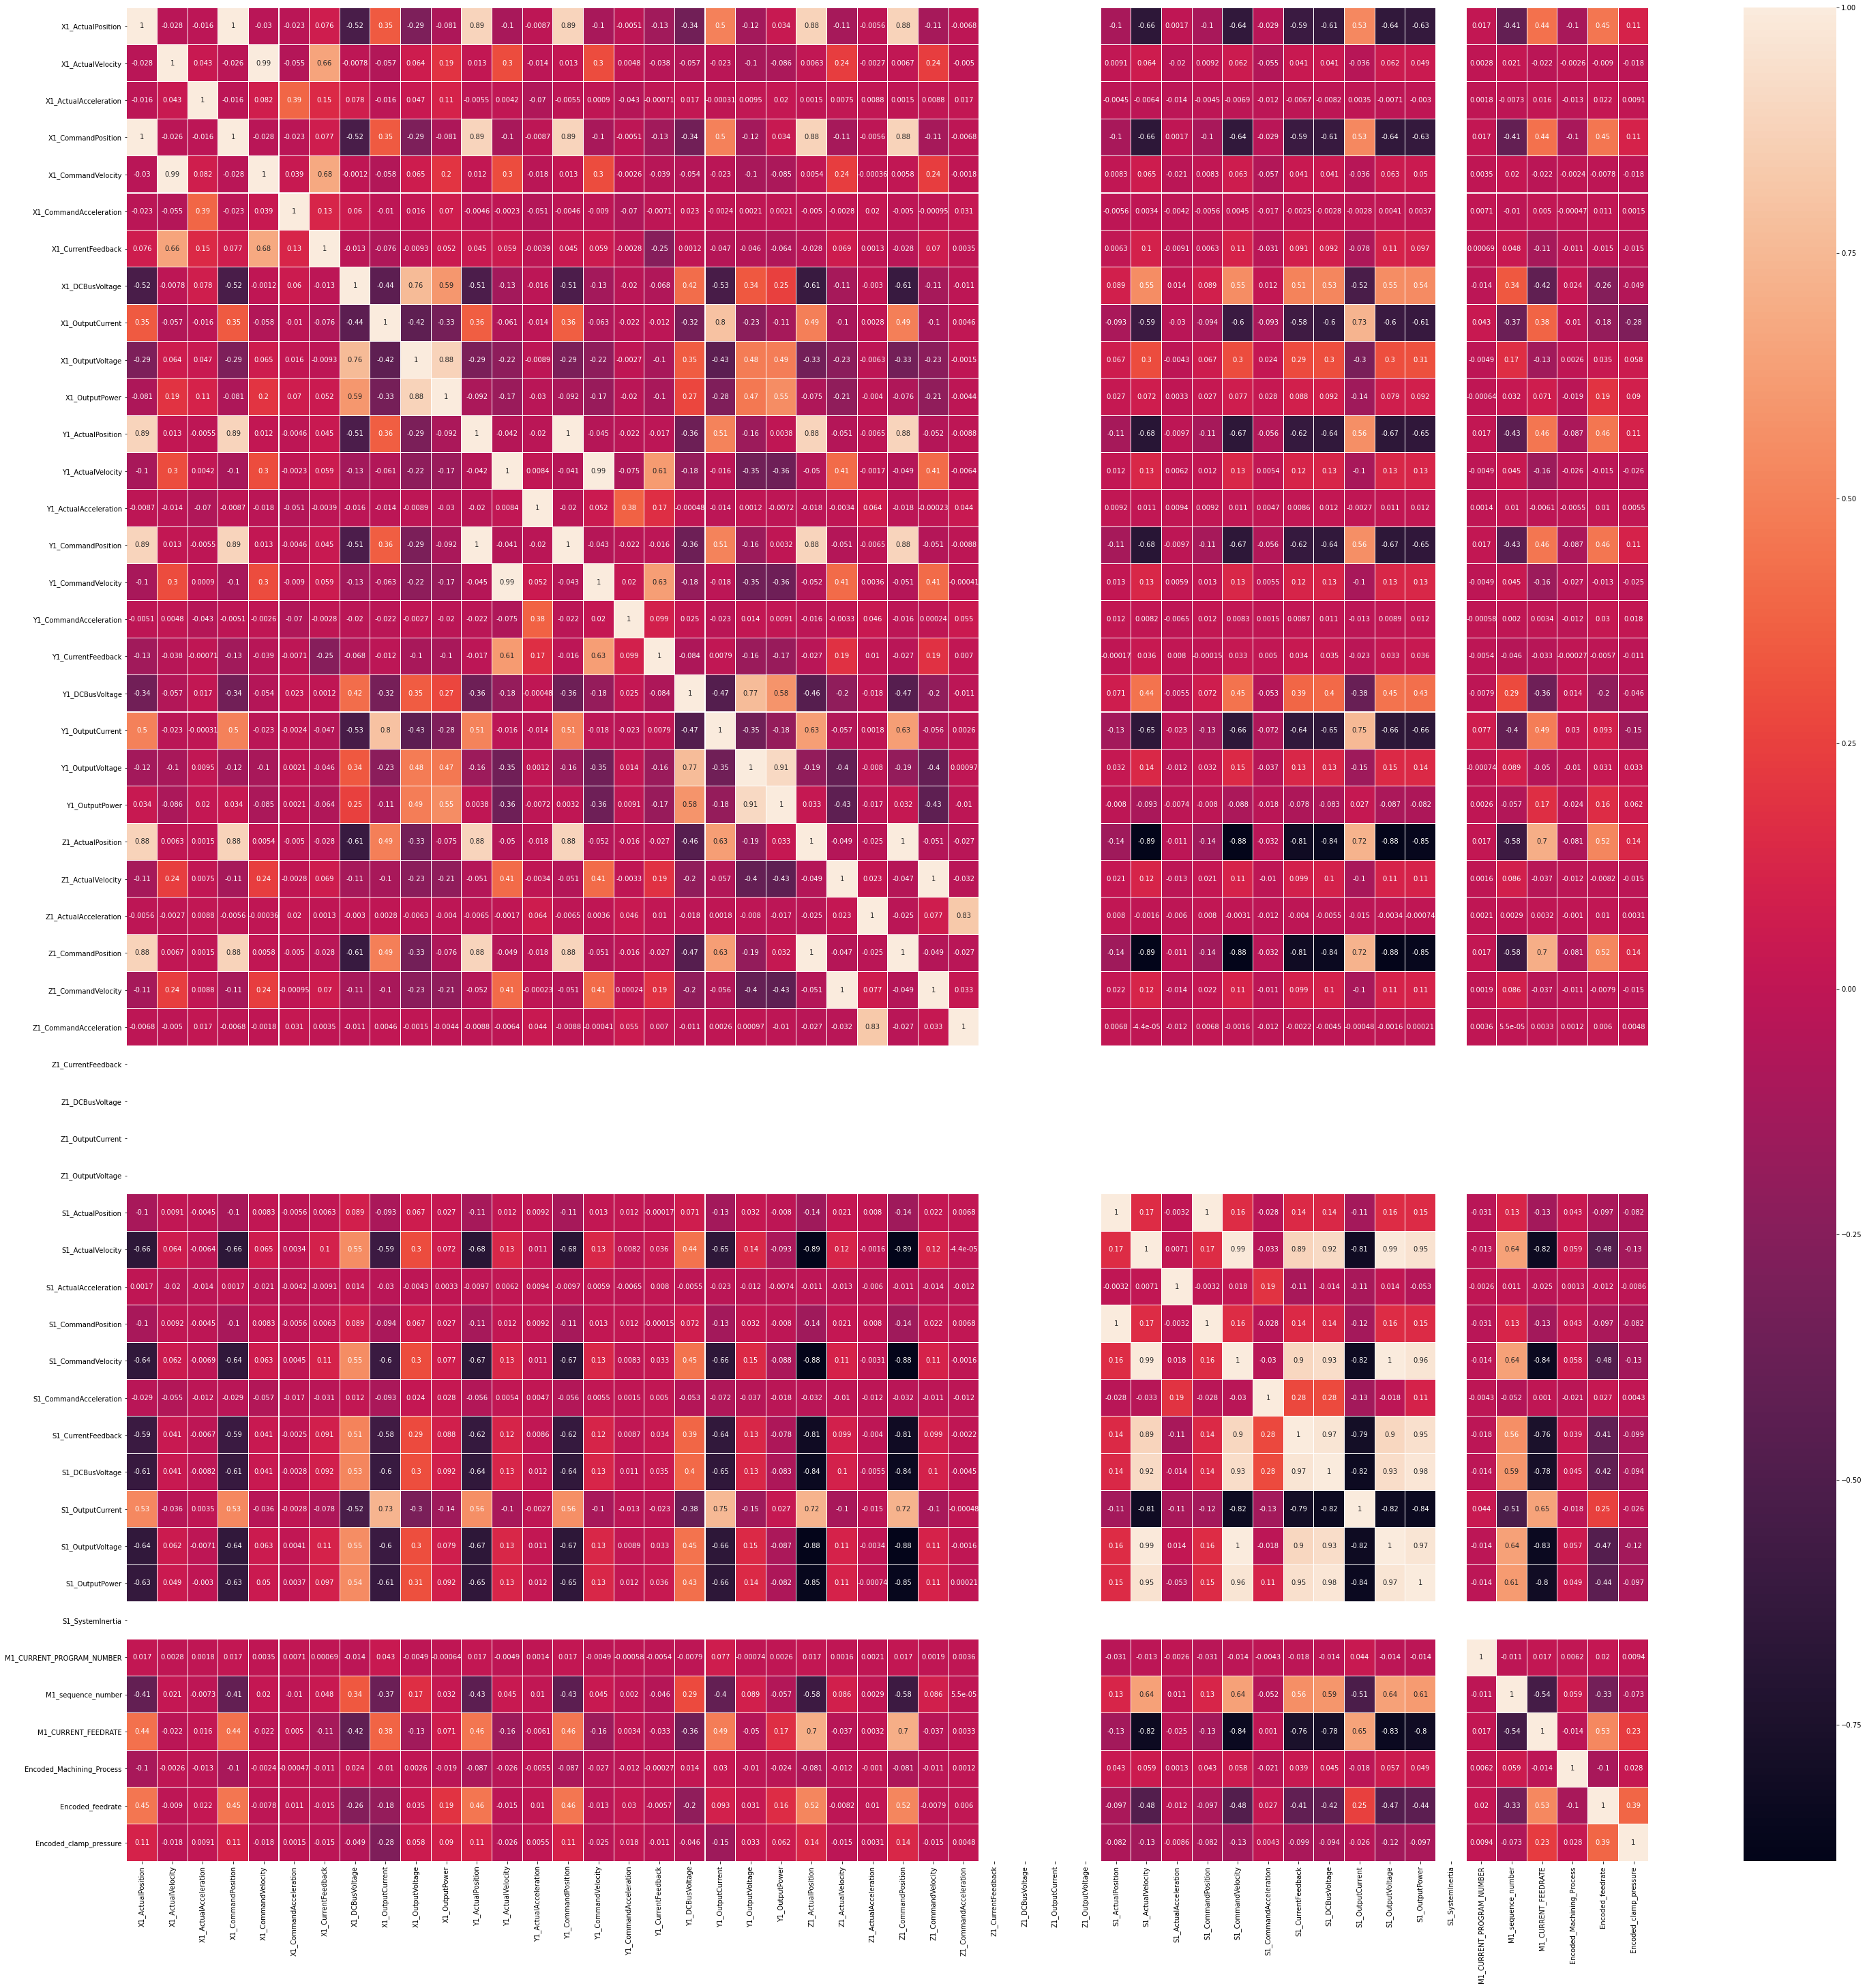

In [71]:
print(">>>>> Heatmap of frames <<<<<")
plt.figure(figsize=(50,50))
sns.heatmap(df.corr(),linewidths=.1,annot=True)
plt.show()
plt.savefig('fig.png')
plt.close('all')

        Use function .drop() remove columns by specifying label names

In [72]:
df.drop(['Z1_CurrentFeedback','Z1_DCBusVoltage','Z1_OutputCurrent','Z1_OutputVoltage','S1_SystemInertia'],axis=1,inplace=True)

>>>>> Heatmap of frames after drop column <<<<<


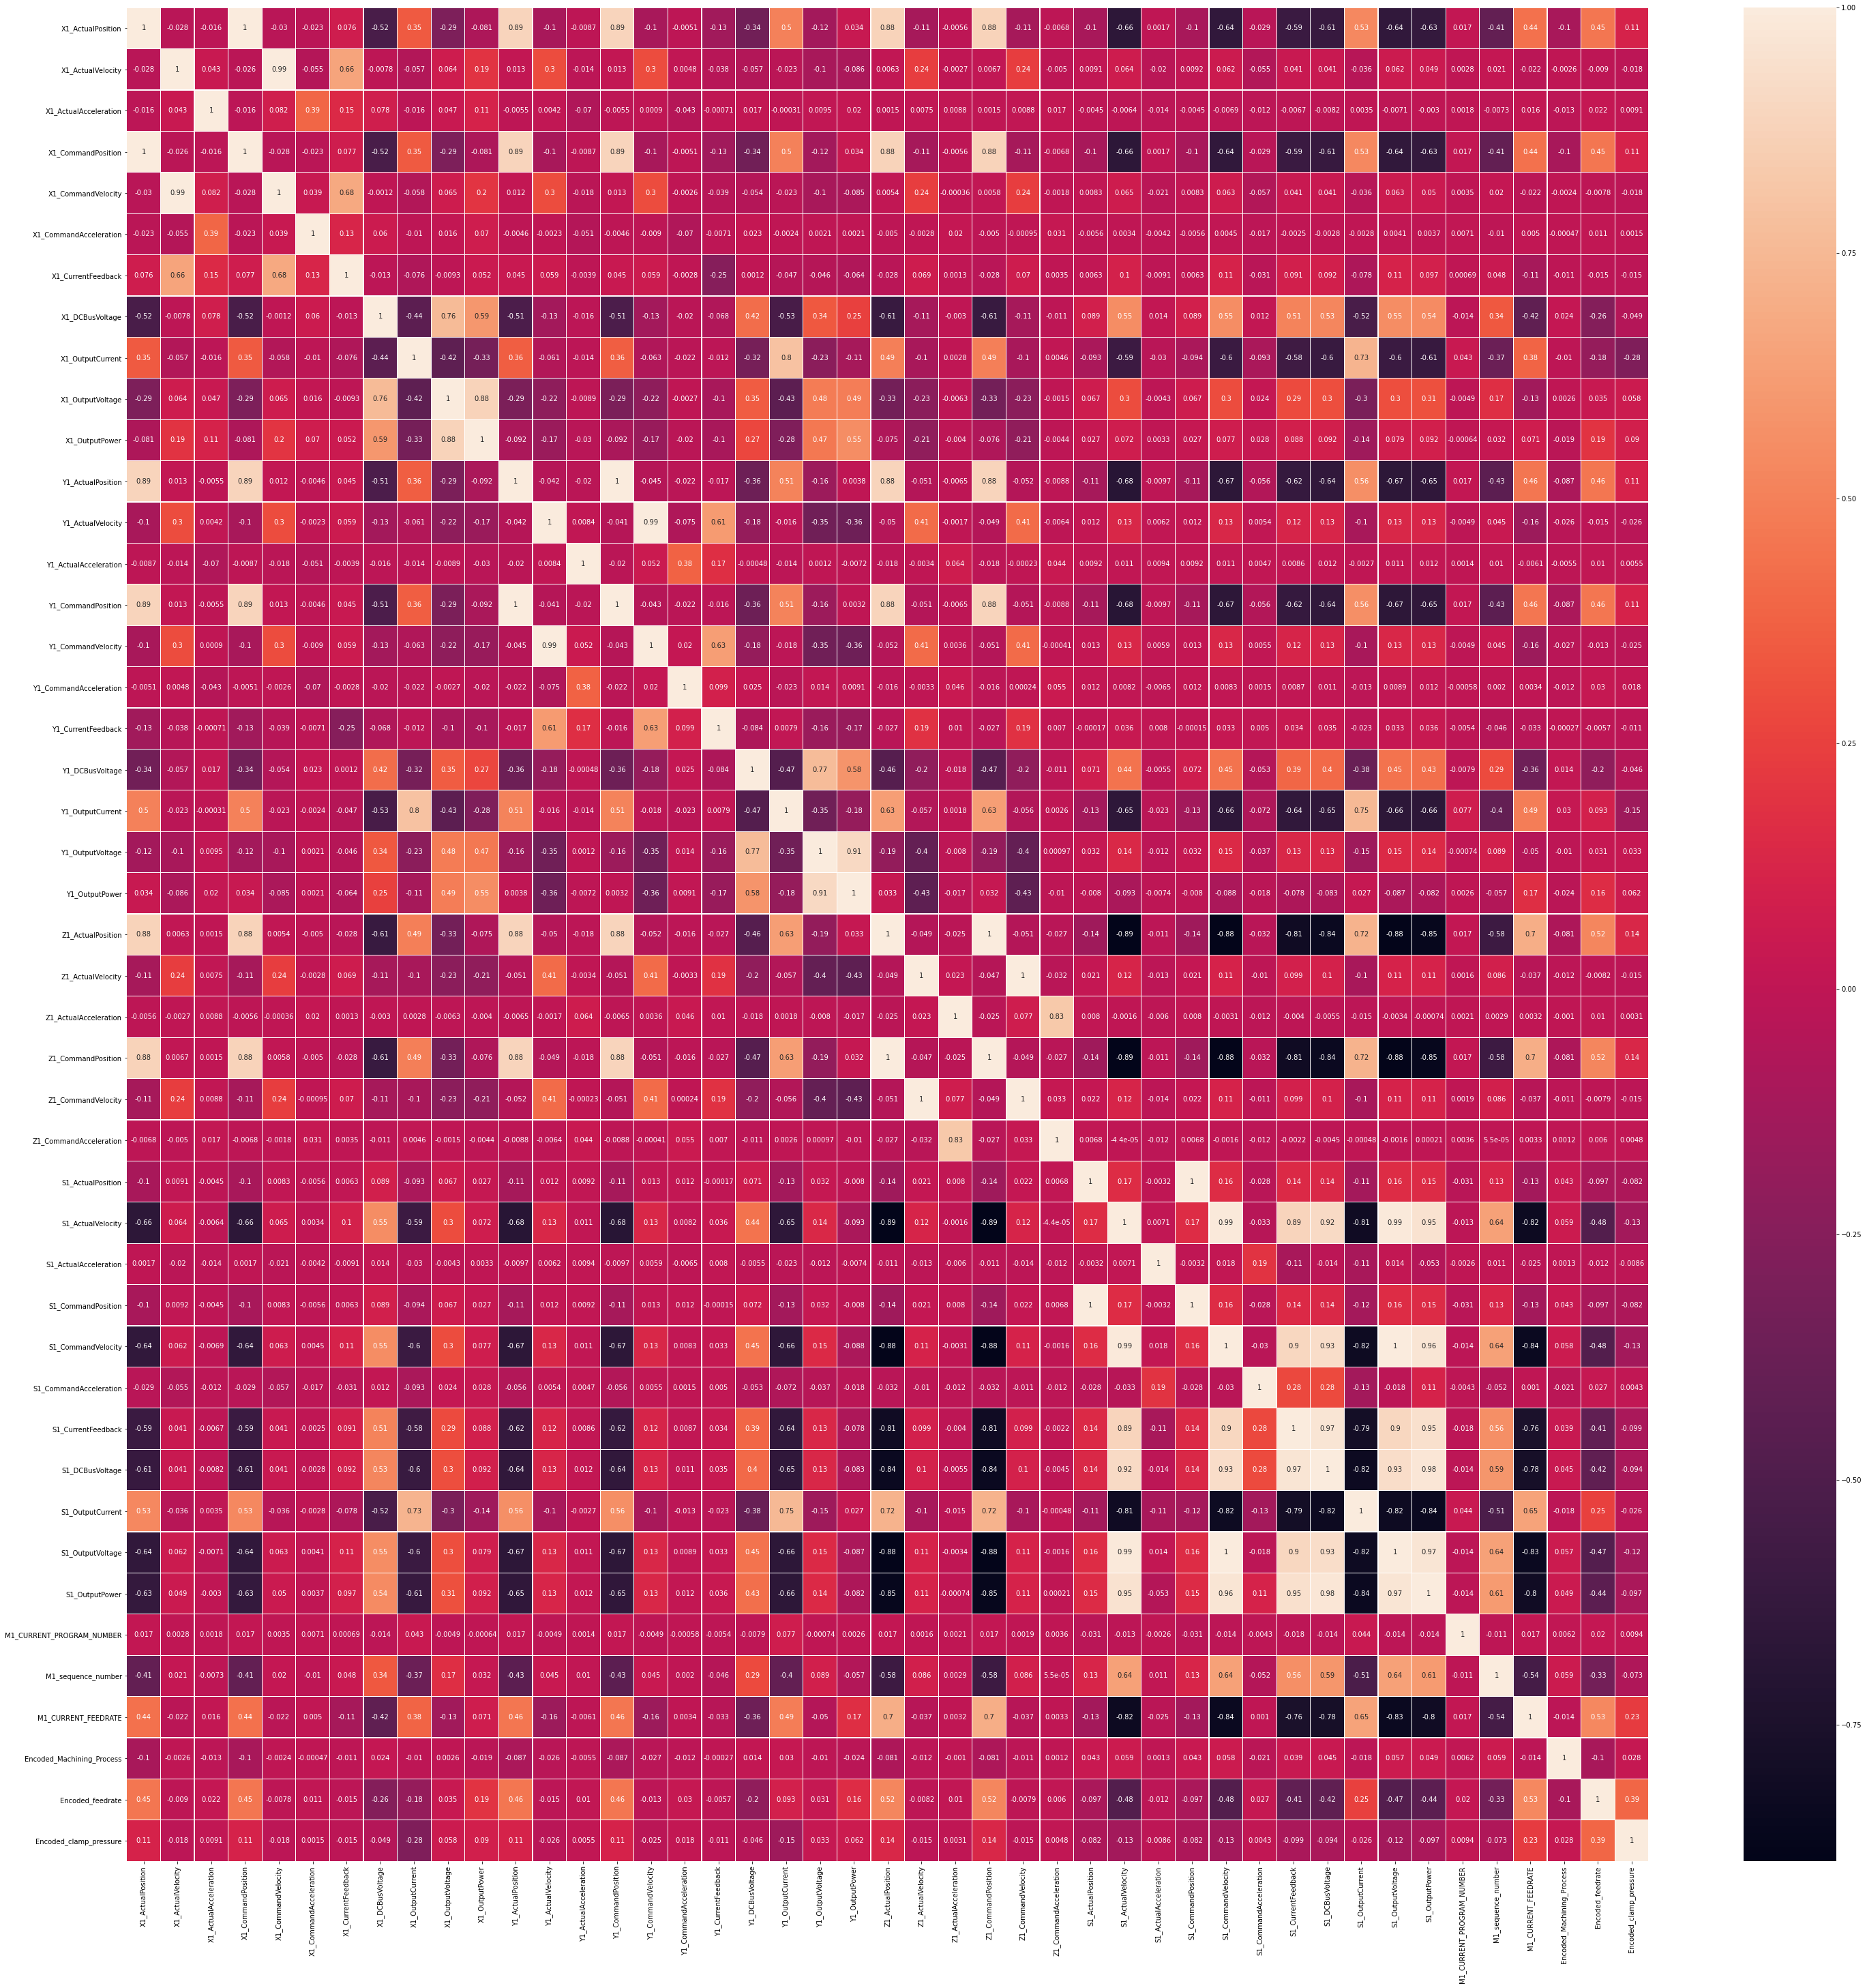

In [73]:
print(">>>>> Heatmap of frames after drop column <<<<<")
plt.figure(figsize=(50,50))
sns.heatmap(df.corr(),linewidths=.1,annot=True)
plt.show()

In [74]:
corr = df.corr()
print("\n>>>>> All features Correlation shape <<<<<")
print(df.corr().shape)


>>>>> All features Correlation shape <<<<<
(45, 45)


        Find features that correlated to 'Encoded_feedrate' with value abs(corr) > 0.3

In [75]:
print("\n>>>>> Encoded_feedrate abs Correlation > 0.3 <<<<<")
cor_feedrate = abs(corr["Encoded_feedrate"])
relevant_features = cor_feedrate[cor_feedrate>0.3]
print(relevant_features)


>>>>> Encoded_feedrate abs Correlation > 0.3 <<<<<
X1_ActualPosition         0.454350
X1_CommandPosition        0.454284
Y1_ActualPosition         0.456606
Y1_CommandPosition        0.456624
Z1_ActualPosition         0.524963
Z1_CommandPosition        0.524995
S1_ActualVelocity         0.475970
S1_CommandVelocity        0.475906
S1_CurrentFeedback        0.411579
S1_DCBusVoltage           0.420048
S1_OutputVoltage          0.473093
S1_OutputPower            0.437202
M1_sequence_number        0.331066
M1_CURRENT_FEEDRATE       0.527989
Encoded_feedrate          1.000000
Encoded_clamp_pressure    0.388734
Name: Encoded_feedrate, dtype: float64


        Select features that highly correlated to 'Encoded_feedrate' into 'newDf_feedrate'

In [76]:
newDf_feedrate = df[['X1_ActualPosition', 'X1_CommandPosition', 'Y1_ActualPosition', 'Y1_CommandPosition', 'Z1_ActualPosition', 'Z1_CommandPosition', 'S1_ActualVelocity', 'S1_CommandVelocity', 'S1_CurrentFeedback', 'S1_DCBusVoltage', 'S1_OutputVoltage', 'S1_OutputPower', 'M1_sequence_number', 'M1_CURRENT_FEEDRATE', 'Encoded_feedrate']]
print("\n---------- newDf feedrate info: ----------")
print(newDf_feedrate.info())
print("---------- newDf feedrate head: ----------")
print(newDf_feedrate.head(3))


---------- newDf feedrate info: ----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25286 entries, 0 to 25285
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   X1_ActualPosition    25286 non-null  float64
 1   X1_CommandPosition   25286 non-null  float64
 2   Y1_ActualPosition    25286 non-null  float64
 3   Y1_CommandPosition   25286 non-null  float64
 4   Z1_ActualPosition    25286 non-null  float64
 5   Z1_CommandPosition   25286 non-null  float64
 6   S1_ActualVelocity    25286 non-null  float64
 7   S1_CommandVelocity   25286 non-null  float64
 8   S1_CurrentFeedback   25286 non-null  float64
 9   S1_DCBusVoltage      25286 non-null  float64
 10  S1_OutputVoltage     25286 non-null  float64
 11  S1_OutputPower       25286 non-null  float64
 12  M1_sequence_number   25286 non-null  float64
 13  M1_CURRENT_FEEDRATE  25286 non-null  float64
 14  Encoded_feedrate     25286 non-null  float

        Find features that correlated to 'Encoded_clamp_pressure' with value abs(corr) > 0.1

In [77]:
print("\n>>>>> Encoded_clamp_pressure abs Correlation > 0.1 <<<<<")
cor_clamp_pressure = abs(corr["Encoded_clamp_pressure"])

#Selecting highly correlated features
relevant_features2 = cor_clamp_pressure[cor_clamp_pressure>0.1]
print(relevant_features2)


>>>>> Encoded_clamp_pressure abs Correlation > 0.1 <<<<<
X1_ActualPosition         0.113518
X1_CommandPosition        0.113517
X1_OutputCurrent          0.283519
Y1_ActualPosition         0.112849
Y1_CommandPosition        0.112847
Y1_OutputCurrent          0.145806
Z1_ActualPosition         0.135540
Z1_CommandPosition        0.135540
S1_ActualVelocity         0.128213
S1_CommandVelocity        0.126779
S1_OutputVoltage          0.121822
M1_CURRENT_FEEDRATE       0.226954
Encoded_feedrate          0.388734
Encoded_clamp_pressure    1.000000
Name: Encoded_clamp_pressure, dtype: float64


        Select features that highly correlated to 'Encoded_clamp_pressure' into 'newDf_pressure'

In [78]:
newDf_pressure = df[['X1_ActualPosition', 'X1_CommandPosition', 'X1_OutputCurrent', 'Y1_ActualPosition', 'Y1_CommandPosition', 'Y1_OutputCurrent', 'Z1_ActualPosition', 'Z1_CommandPosition', 'S1_ActualVelocity', 'S1_CommandVelocity', 'S1_OutputVoltage', 'M1_CURRENT_FEEDRATE', 'Encoded_clamp_pressure']]
print("\n---------- newDf pressure info: ----------")
print(newDf_pressure.info())
print("---------- newDf pressure head: ----------")
print(newDf_pressure.head(3))


---------- newDf pressure info: ----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25286 entries, 0 to 25285
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   X1_ActualPosition       25286 non-null  float64
 1   X1_CommandPosition      25286 non-null  float64
 2   X1_OutputCurrent        25286 non-null  float64
 3   Y1_ActualPosition       25286 non-null  float64
 4   Y1_CommandPosition      25286 non-null  float64
 5   Y1_OutputCurrent        25286 non-null  float64
 6   Z1_ActualPosition       25286 non-null  float64
 7   Z1_CommandPosition      25286 non-null  float64
 8   S1_ActualVelocity       25286 non-null  float64
 9   S1_CommandVelocity      25286 non-null  float64
 10  S1_OutputVoltage        25286 non-null  float64
 11  M1_CURRENT_FEEDRATE     25286 non-null  float64
 12  Encoded_clamp_pressure  25286 non-null  float64
dtypes: float64(13)
memory usage: 2.5 MB
None
------

# **5. Prediction**

**Predict feedrate**

        Split arrays into random train 70% and test 30% subsets

In [79]:
'''
y=newDf_feedrate['Encoded_feedrate']
X=newDf_feedrate.drop(['Encoded_feedrate'], axis=1)
print("\n========== y.newDf_feedrate(3) ==========")
print(y.head(3))
print("\n========== X.newDf_feedrate(3) ==========")
print(X.head(3))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)
'''

'\ny=newDf_feedrate[\'Encoded_feedrate\']\nX=newDf_feedrate.drop([\'Encoded_feedrate\'], axis=1)\nprint("\n========== y.newDf_feedrate(3) ==========")\nprint(y.head(3))\nprint("\n========== X.newDf_feedrate(3) ==========")\nprint(X.head(3))\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)\n'

**Feedrate model fitting**

        Logistic regression model

In [80]:
'''
LR_feedrate = LogisticRegression(C=1e20)
LR_feedrate.fit(X_train, y_train)
print(cross_val_score(LR_feedrate, X_test, y_test, cv=5, scoring='accuracy'))
print("\n========== Logistic Regression score of feedrate ==========")
print(LR_feedrate.score(X_test,y_test))
'''

'\nLR_feedrate = LogisticRegression(C=1e20)\nLR_feedrate.fit(X_train, y_train)\nprint(cross_val_score(LR_feedrate, X_test, y_test, cv=5, scoring=\'accuracy\'))\nprint("\n========== Logistic Regression score of feedrate ==========")\nprint(LR_feedrate.score(X_test,y_test))\n'

        Support vector machine model

In [81]:
'''
SVM_feedrate = svm.SVC()
SVM_feedrate.fit(X_train, y_train)
print(cross_val_score(SVM_feedrate, X_test, y_test, cv=5, scoring='accuracy'))
print("\n========== Support vector machine score of feedrate  ==========")
print(SVM_feedrate.score(X_test, y_test))
'''

'\nSVM_feedrate = svm.SVC()\nSVM_feedrate.fit(X_train, y_train)\nprint(cross_val_score(SVM_feedrate, X_test, y_test, cv=5, scoring=\'accuracy\'))\nprint("\n========== Support vector machine score of feedrate  ==========")\nprint(SVM_feedrate.score(X_test, y_test))\n'

        Neural network model

In [82]:
'''
mlp_feedrate = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
mlp_feedrate.fit(X_train, y_train)
print(cross_val_score(mlp_feedrate, X_test, y_test, cv=5, scoring='accuracy'))
print("\n========== MLPClassifier score of feedrate  ==========")
print(mlp_feedrate.score(X_test, y_test))
'''

'\nmlp_feedrate = MLPClassifier(solver=\'lbfgs\', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)\nmlp_feedrate.fit(X_train, y_train)\nprint(cross_val_score(mlp_feedrate, X_test, y_test, cv=5, scoring=\'accuracy\'))\nprint("\n========== MLPClassifier score of feedrate  ==========")\nprint(mlp_feedrate.score(X_test, y_test))\n'

        Nearest neighbors model

In [83]:
'''
nrc_feedrate= NearestCentroid()
nrc_feedrate.fit(X_train, y_train)
print(cross_val_score(nrc_feedrate, X_test, y_test, cv=5, scoring='accuracy'))
print("\n========== NearestCentroid score of feedrate  ==========")
print(nrc_feedrate.score(X_test, y_test))
'''

'\nnrc_feedrate= NearestCentroid()\nnrc_feedrate.fit(X_train, y_train)\nprint(cross_val_score(nrc_feedrate, X_test, y_test, cv=5, scoring=\'accuracy\'))\nprint("\n========== NearestCentroid score of feedrate  ==========")\nprint(nrc_feedrate.score(X_test, y_test))\n'

        Stochastic gradient descent model

In [84]:
'''
SGD_feedrate= SGDClassifier(loss="hinge", penalty="l2", max_iter=5)
SGD_feedrate.fit(X_train, y_train)
print(cross_val_score(SGD_feedrate, X_test, y_test, cv=5, scoring='accuracy'))
print("\n========== SGDClassifier score of feedrate  ==========")
print(SGD_feedrate.score(X_test, y_test))
'''

'\nSGD_feedrate= SGDClassifier(loss="hinge", penalty="l2", max_iter=5)\nSGD_feedrate.fit(X_train, y_train)\nprint(cross_val_score(SGD_feedrate, X_test, y_test, cv=5, scoring=\'accuracy\'))\nprint("\n========== SGDClassifier score of feedrate  ==========")\nprint(SGD_feedrate.score(X_test, y_test))\n'

        Decision trees model

In [85]:
'''
tree_feedrate = tree.DecisionTreeClassifier()
tree_feedrate.fit(X_train, y_train)
print(cross_val_score(tree_feedrate, X_test, y_test, cv=5, scoring='accuracy'))
print("\n========== DecisionTreeClassifier score of feedrate  ==========")
print(tree_feedrate.score(X_test, y_test))
'''

'\ntree_feedrate = tree.DecisionTreeClassifier()\ntree_feedrate.fit(X_train, y_train)\nprint(cross_val_score(tree_feedrate, X_test, y_test, cv=5, scoring=\'accuracy\'))\nprint("\n========== DecisionTreeClassifier score of feedrate  ==========")\nprint(tree_feedrate.score(X_test, y_test))\n'

**Use 'Decision trees model' to predict feedrate data**

In [86]:
'''
predictions_feedrate = tree_feedrate.predict(X_test)
print("\n========== Prediction_feedrate results  ==========")
print(predictions_feedrate)
'''

'\npredictions_feedrate = tree_feedrate.predict(X_test)\nprint("\n========== Prediction_feedrate results  ==========")\nprint(predictions_feedrate)\n'

**Predict Clamp_pressure**

        Split arrays into random train 70% and test 30% subsets

In [87]:
'''
y1=newDf_pressure['Encoded_clamp_pressure']
X1=newDf_pressure.drop(['Encoded_clamp_pressure'], axis=1)
print("\n========== y.head(3) ==========")
print(y1.head(3))
print("\n========== X.head(3) ==========")
print(X1.head(3))
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=7)
'''

'\ny1=newDf_pressure[\'Encoded_clamp_pressure\']\nX1=newDf_pressure.drop([\'Encoded_clamp_pressure\'], axis=1)\nprint("\n========== y.head(3) ==========")\nprint(y1.head(3))\nprint("\n========== X.head(3) ==========")\nprint(X1.head(3))\nX1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=7)\n'

**Pressure model fitting**

        Logistic regression model

In [88]:
'''
LR_pressure = LogisticRegression(C=1e20)
LR_pressure.fit(X1_train, y1_train)
print(cross_val_score(LR_pressure, X_test, y_test, cv=5, scoring='accuracy'))
print("\n========== Logistic Regression score of pressure ==========")
print(LR_pressure.score(X1_test,y1_test))
'''

'\nLR_pressure = LogisticRegression(C=1e20)\nLR_pressure.fit(X1_train, y1_train)\nprint(cross_val_score(LR_pressure, X_test, y_test, cv=5, scoring=\'accuracy\'))\nprint("\n========== Logistic Regression score of pressure ==========")\nprint(LR_pressure.score(X1_test,y1_test))\n'

        Support vector machine model

In [89]:
'''
SVM_pressure = svm.SVC()
SVM_pressure.fit(X1_train, y1_train)
print("\n========== Support vector machine score of pressure  ==========")
print(SVM_pressure.score(X1_test, y1_test))
'''

'\nSVM_pressure = svm.SVC()\nSVM_pressure.fit(X1_train, y1_train)\nprint("\n========== Support vector machine score of pressure  ==========")\nprint(SVM_pressure.score(X1_test, y1_test))\n'

        Neural network model

In [90]:
'''
mlp_pressure = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
mlp_pressure.fit(X1_train, y1_train)
print("\n========== MLPClassifier score of pressure  ==========")
print(mlp_pressure.score(X1_test, y1_test))
'''

'\nmlp_pressure = MLPClassifier(solver=\'lbfgs\', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)\nmlp_pressure.fit(X1_train, y1_train)\nprint("\n========== MLPClassifier score of pressure  ==========")\nprint(mlp_pressure.score(X1_test, y1_test))\n'

        Nearest neighbors model

In [91]:
'''
nrc_pressure= NearestCentroid()
mlp_pressure.fit(X1_train, y1_train)
print("\n========== NearestCentroid score of pressure  ==========")
print(mlp_pressure.score(X1_test, y1_test))
'''

'\nnrc_pressure= NearestCentroid()\nmlp_pressure.fit(X1_train, y1_train)\nprint("\n========== NearestCentroid score of pressure  ==========")\nprint(mlp_pressure.score(X1_test, y1_test))\n'

        Stochastic gradient descent model

In [92]:
'''
SGD_pressure= SGDClassifier(loss="hinge", penalty="l2", max_iter=5)
SGD_pressure.fit(X1_train, y1_train)
print("\n========== SGDClassifier score of pressure  ==========")
print(SGD_pressure.score(X1_test, y1_test))
'''

'\nSGD_pressure= SGDClassifier(loss="hinge", penalty="l2", max_iter=5)\nSGD_pressure.fit(X1_train, y1_train)\nprint("\n========== SGDClassifier score of pressure  ==========")\nprint(SGD_pressure.score(X1_test, y1_test))\n'

        Decision trees model

In [93]:
'''
tree_pressure = tree.DecisionTreeClassifier()
tree_pressure.fit(X1_train, y1_train)
print("\n========== DecisionTreeClassifier score of pressure  ==========")
print(tree_pressure.score(X1_test, y1_test))
'''

'\ntree_pressure = tree.DecisionTreeClassifier()\ntree_pressure.fit(X1_train, y1_train)\nprint("\n========== DecisionTreeClassifier score of pressure  ==========")\nprint(tree_pressure.score(X1_test, y1_test))\n'

**Use 'Decision trees model' to predict pressure data**

In [94]:
'''
predictions_pressure = tree_pressure.predict(X1_test)
print("\n========== Prediction_pressure results  ==========")
print(predictions_pressure)
'''

'\npredictions_pressure = tree_pressure.predict(X1_test)\nprint("\n========== Prediction_pressure results  ==========")\nprint(predictions_pressure)\n'

Combine Predicted feedrate and Predicted Pressure to 'finalDf' dataframe

In [152]:

finalDf = pd.DataFrame(columns=['feedrate','clampPressure'])
finalDf['feedrate'] = np.random.choice(5, 20).tolist()
finalDf['clampPressure'] = np.random.choice(5, 20).tolist()

#finalDf['feedrate'] = df['Encoded_feedrate'].tolist()
#finalDf['clampPressure'] = df['Encoded_clamp_pressure'].tolist()


print("----- finalDf.info() -----")
print(finalDf.info())
print("----- finalDf.head(3) -----")
print(finalDf.head(3))


----- finalDf.info() -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   feedrate       20 non-null     int64
 1   clampPressure  20 non-null     int64
dtypes: int64(2)
memory usage: 448.0 bytes
None
----- finalDf.head(3) -----
   feedrate  clampPressure
0         3              2
1         4              1
2         4              1


**Predict Tool_Condition**

        Split arrays into random train 70% and test 30% subsets

In [96]:
y_final=train['Encoded_tool_condition']
X_final=train[['Encoded_feedrate', 'Encoded_clamp_pressure']]
X_final_train, X_final_test, y_final_train, y_final_test = train_test_split(X_final, y_final, test_size=0.3, random_state=7)

**Tool_Condition model fitting**

        Logistic regression model

In [97]:
LR_tool_condition = LogisticRegression(C=1e20)
LR_tool_condition.fit(X_final_train, y_final_train)
print(cross_val_score(LR_tool_condition, X_test, y_test, cv=5, scoring='accuracy'))
print("\n========== LogisticRegression score of tool_condition  ==========")
print(LR_tool_condition.score(X_final_test, y_final_test))

[0.58695652 0.58602505 0.58272907 0.58932103 0.59986816]

========== LogisticRegression score of tool_condition  ==========
0.5


        Support vector machine model

In [98]:
SVM_tool_condition = svm.SVC()
SVM_tool_condition.fit(X_final_train, y_final_train)
print(cross_val_score(SVM_tool_condition, X_test, y_test, cv=5, scoring='accuracy'))
print("\n========== Support vector machine score of tool_condition  ==========")
print(SVM_tool_condition.score(X_final_test, y_final_test))

[0.64888011 0.65194463 0.64733026 0.64996704 0.66183256]

========== Support vector machine score of tool_condition  ==========
0.5


        Neural network model

In [99]:
mlp_tool_condition = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
mlp_tool_condition.fit(X_final_train, y_final_train)
print("\n========== MLPClassifier score of tool_condition  ==========")
print(mlp_tool_condition.score(X_final_test, y_final_test))


========== MLPClassifier score of tool_condition  ==========
0.3333333333333333


        Nearest neighbors model

In [100]:
nrc_tool_condition= NearestCentroid()
nrc_tool_condition.fit(X_final_train, y_final_train)
print(cross_val_score(nrc_tool_condition, X_test, y_test, cv=5, scoring='accuracy'))
print("\n========== NearestCentroid score of tool_condition  ==========")
print(nrc_tool_condition.score(X_final_test, y_final_test))

[0.60144928 0.58602505 0.57350033 0.58998022 0.59657218]

========== NearestCentroid score of tool_condition  ==========
0.5


        Stochastic gradient descent model

In [101]:
SGD_tool_condition= SGDClassifier(loss="hinge", penalty="l2", max_iter=5)
SGD_tool_condition.fit(X_final_train, y_final_train)
print("\n========== SGDClassifier score of tool_condition  ==========")
print(SGD_tool_condition.score(X_final_test, y_final_test))


========== SGDClassifier score of tool_condition  ==========
0.6666666666666666


        Decision trees model

In [102]:
tree_tool_condition = tree.DecisionTreeClassifier()
tree_tool_condition.fit(X_final_train, y_final_train)
print(cross_val_score(tree_tool_condition, X_test, y_test, cv=5, scoring='accuracy'))
print("\n========== DecisionTreeClassifier score of tool_condition  ==========")
print(tree_tool_condition.score(X_final_test, y_final_test))

[0.91963109 0.92880686 0.91957811 0.91430455 0.92551088]

========== DecisionTreeClassifier score of tool_condition  ==========
0.3333333333333333


**Use 'Stochastic gradient descent model' to predict tool_condition data**

In [148]:
predictions_tool_condition = tree_tool_condition.predict(X_final_test)
print("\n========== predictions_tool_condition results  ==========")
print(predictions_tool_condition)


========== predictions_tool_condition results  ==========
[0 0 1 1 0 0]


        Predict 'Tool_Condition' form 'finalDf' dataframe 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Feedrate        20 non-null     int64
 1   Clamp_Pressure  20 non-null     int64
 2   Tool_Condition  20 non-null     int64
dtypes: int64(3)
memory usage: 608.0 bytes
None


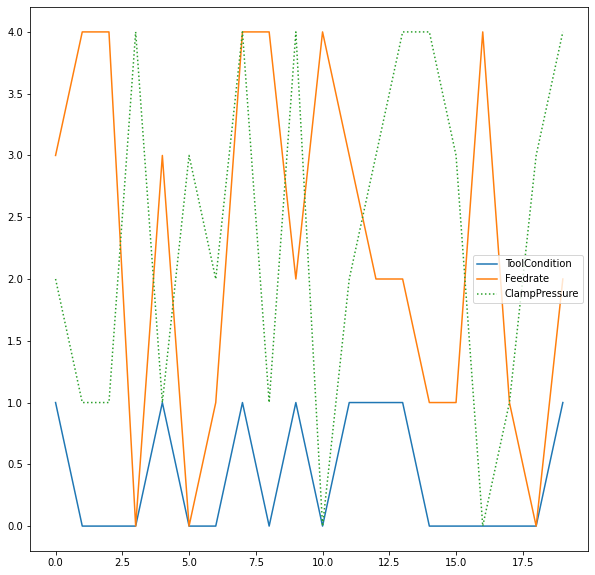

In [153]:
pred=tree_tool_condition.predict(finalDf)
output=pd.DataFrame({'Feedrate':finalDf['feedrate'], 'Clamp_Pressure':finalDf['clampPressure'], 'Tool_Condition':pred})
print(output.info())

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.plot(pred)
plt.plot(finalDf['feedrate'])
plt.plot(finalDf['clampPressure'], ':')
plt.legend(['ToolCondition', 'Feedrate', 'ClampPressure'])
plt.show()

# **6. Result**

Decode lebel from 'finalDf' dataframe 

In [149]:
finalDf['feedrate'] = finalDf['feedrate'].apply(np.sign).replace({0.0: 3, 0.1: 6, 0.2: 12, 0.3: 15, 0.4:20})
finalDf['clampPressure'] = finalDf['clampPressure'].apply(np.sign).replace({0.0: 2.5, 0.1: 3.0, 0.2: 4.0})
pred = pred.astype(str)
for i in range(len(pred)):
    if (pred[i]=='0'):
        pred[i]='unworn'
    elif (pred[i]=='1'):
        pred[i]='worn'

Show output with decoded label result

In [150]:
output=pd.DataFrame({'Feedrate':finalDf['feedrate'], 'Clamp_Pressure':finalDf['clampPressure'], 'Tool_Condition':pred})
print(output.head())

   Feedrate  Clamp_Pressure Tool_Condition
0       1.0             1.0         unworn
1       1.0             1.0         unworn
2       1.0             1.0         unworn
3       1.0             1.0         unworn
4       1.0             1.0         unworn
